<font size="5"><center> **Exercise 1.4** </center></font>
<font size="4"><center> CS-673 <br> Introduction to Deep Generative Models </center></font>
<font size="4"><center> Sifakis Emmanouil, *1288* </center></font>

---

↓ Imports ↓

In [1]:
# IMPORTS
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

⇒ Question b

In [2]:
def regularize_covariance_matrix(Sigma):
  Sigma_reg = Sigma.copy()
  for i in range(len(Sigma)):
      # Perform eigenvalue decomposition
      eigenvalues, eigenvectors = np.linalg.eigh(Sigma[i])
      # Ensure positive eigenvalues (Regularization)
      eigenvalues[eigenvalues < 0] = 0.5  # Or any small positive value
      # Reconstruct the covariance matrix
      Sigma_reg[i] = np.dot(eigenvectors, np.dot(np.diag(eigenvalues), eigenvectors.T))
  return Sigma_reg

In [3]:
# initialization of Parameters
K = 3
n = 1000
pi = np.array([1/3, 1/3, 1/3])  # Weights
mu = np.array([[0, 1], [1, -0.5], [0, 0]], dtype=float)
Sigma = np.array([[[1, 0.5], [0.5, 0.9]], [[1, -0.8], [-0.8, 1.1]], [[1.5, 1.3], [1.3, 1]]], dtype=float)
samples = np.zeros((n, K-1))

# Regularize covariance matrices
Sigma_reg = regularize_covariance_matrix(Sigma)
for i in range(K):
    # Perform eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(Sigma_reg[i])
    # Ensure positive eigenvalues (Reqularization)
    eigenvalues[eigenvalues < 0] = 0.5
    # Reconstruct the covariance matrix
    Sigma_reg[i] = np.dot(eigenvectors, np.dot(np.diag(eigenvalues), eigenvectors.T))

for i in range(n):
    # Select a component based on the weights
    component = np.random.choice(K, p=pi)
    # Generate sample from the chosen component
    sample = np.random.multivariate_normal(mu[component], Sigma_reg[component])
    samples[i] = sample


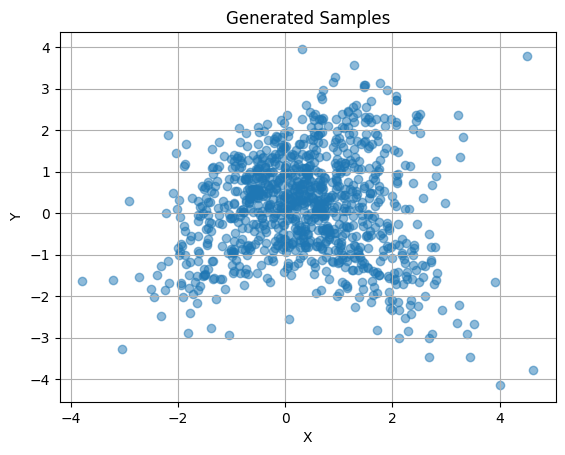

In [4]:
# Plot the generated samples
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Generated Samples')
plt.grid(True)
plt.show()

⇒ Question c

Parameter update stepS of the Expectation-Maximization (EM) algorithm for Gaussian Mixture Models (GMMs) with prior knowledge about the mean vectors.

1. **E-step**:<br>
$
\gamma_{ij}^{(t)} = \frac{\pi_j \cdot \mathcal{N}(x_i | \mu_j, \Sigma_j)}{\sum_{k=1}^K \pi_k \cdot \mathcal{N}(x_i | \mu_k, \Sigma_k)}
$

2. **M-step (for updating mixture weights $\pi$)**:<br>
$
\pi_j = \frac{\sum_{i=1}^N \gamma_{ij}^{(t)}}{N}
$

3. **M-step (for updating mean vectors $\mu_j$)**:<br>
$
\mu_j = \frac{\sum_{i=1}^N \gamma_{ij}^{(t)} x_i + \lambda \mu_{0j}}{\sum_{i=1}^N \gamma_{ij}^{(t)} + \lambda}
$

4. **M-step (for updating covariance matrices $\Sigma_j$)**:<br>
$
\Sigma_j = \frac{\sum_{i=1}^N \gamma_{ij}^{(t)} (x_i - \mu_j)(x_i - \mu_j)^\top}{\sum_{i=1}^N \gamma_{ij}^{(t)}}
$

*Run Below cases in order


In [52]:
def generate_samples_from_GMM(n, d, true_means, true_covariances, true_weights):
    np.random.seed(198)
    samples = np.zeros((n, d))
    components = np.random.choice(np.arange(len(true_weights)), size=n, p=true_weights)
    for i in range(n):
        samples[i] = np.random.multivariate_normal(true_means[components[i]], true_covariances[components[i]])
    return samples


def generate_est(n, d, pi, mu, Sigma):
    # Generate samples using the estimated parameters
    estimated_samples = np.zeros((n, d))
    for i in range(n):
        component = np.random.choice(np.arange(len(pi)), p=pi)
        estimated_samples[i] = np.random.multivariate_normal(mu[component], Sigma[component])

    return estimated_samples

def em_algorithm(samples, initial_means, initial_covariances, initial_weights, lambda_val, true_means, max_iter=100, tolerance=1e-6):
    n, d = samples.shape
    K = initial_means.shape[0]

    # Initialize parameters
    mu = initial_means.copy()
    pi = initial_weights.copy()
    Sigma = initial_covariances.copy()

    for _ in range(max_iter):
        # E-step
        gamma = np.zeros((n, K))
        for j in range(K):
            gamma[:, j] = pi[j] * np.exp(-0.5 * np.sum((samples - mu[j]) @ np.linalg.inv(Sigma[j]) * (samples - mu[j]), axis=1)) / np.sqrt(np.linalg.det(2 * np.pi * Sigma[j]))
        gamma /= np.sum(gamma, axis=1, keepdims=True)

        # M-step
        Nk = np.sum(gamma, axis=0)
        pi = Nk / n
        for j in range(K):
            mu[j] = (np.sum(gamma[:, j] * samples.T, axis=1) + lambda_val * true_means[j]) / (Nk[j] + lambda_val)
            Sigma[j] = np.dot((gamma[:, j].reshape(-1, 1) * (samples - mu[j])).T, (samples - mu[j])) / Nk[j]

        # Check for convergence
        if np.max(np.abs(mu - initial_means)) < tolerance:
            break
        else:
            initial_means = mu.copy()

    return pi, mu, Sigma

Case i

<ipython-input-52-e0e1327d9b50>:6: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples[i] = np.random.multivariate_normal(true_means[components[i]], true_covariances[components[i]])


Estimated Mixture Weights:
[0.38111904 0.35282273 0.26605823]

Estimated Mean Vectors:
[[-1.26123899e-03  9.98710042e-01]
 [ 9.97203695e-01 -5.03539280e-01]
 [-9.90655400e-04 -8.77874730e-04]]

Estimated Covariance Matrices:
[[[ 0.98938025  0.16672758]
  [ 0.16672758  0.59635566]]

 [[ 1.31034637 -1.15505002]
  [-1.15505002  1.40624517]]

 [[ 1.19589339  1.03759866]
  [ 1.03759866  0.97160108]]]


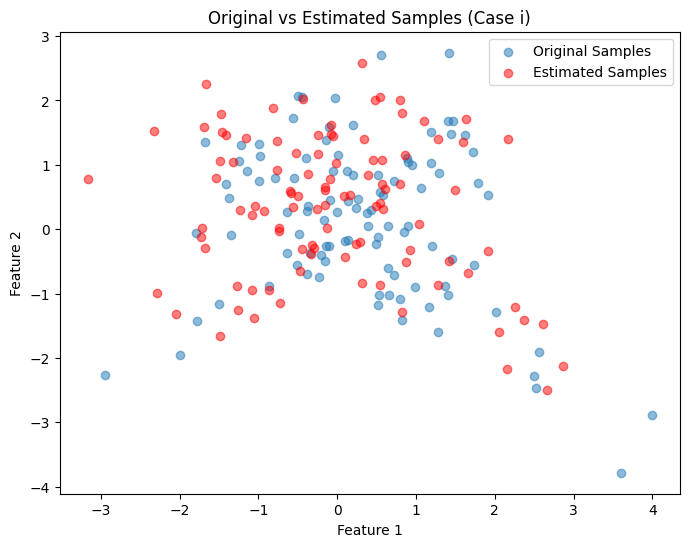

In [53]:
# MAIN for Case i
# Initialize Parameters
K = 3  # Number of components
n = 100  # Number of samples
d = K-1  # Data dimension

# True parameters
true_means = np.array([[0, 1], [1, -0.5], [0, 0]])
true_covariances = np.array([[[1, 0.5], [0.5, 0.9]], [[1, -0.8], [-0.8, 1.1]], [[1.5, 1.3], [1.3, 1]]])
true_weights = np.ones(K) / K

# Samples from the true GMM
samples = generate_samples_from_GMM(n, d, true_means, true_covariances, true_weights)

# Initialize parameters for EM
initial_means = samples[np.random.choice(np.arange(n), size=K, replace=False)]

# Initialize other parameters
initial_weights = true_weights  # Use true_weights instead of pi
initial_covariances = np.array([np.eye(d) for _ in range(K)])

# Define prior parameters
lambda_val = 1e3  # Strength of the prior

# EM algorithm
pi, mu, Sigma = em_algorithm(samples, initial_means, initial_covariances, initial_weights, lambda_val, true_means, max_iter=100, tolerance=1e-6)

# Output estimated parameters
print("Estimated Mixture Weights:")
print(pi)
print("\nEstimated Mean Vectors:")
print(mu)
print("\nEstimated Covariance Matrices:")
print(Sigma)

# Generate estimated samples using the estimated parameters
estimated_samples_1 = generate_est(n, d, pi, mu, Sigma)

# Scatter plot for original and estimated samples
plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label='Original Samples')
plt.scatter(estimated_samples_1[:, 0], estimated_samples_1[:, 1], color='red', alpha=0.5, label='Estimated Samples')
plt.title('Original vs Estimated Samples (Case i)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


<ipython-input-52-e0e1327d9b50>:6: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples[i] = np.random.multivariate_normal(true_means[components[i]], true_covariances[components[i]])


Estimated Mixture Weights:
[0.02834089 0.03755756 0.93410155]

Estimated Mean Vectors:
[[0.99398661 1.99224195]
 [1.98817096 0.49382109]
 [0.94897535 0.93377802]]

Estimated Covariance Matrices:
[[[ 5.36090379  6.93718226]
  [ 6.93718226  8.99137519]]

 [[11.88705031  6.3463524 ]
  [ 6.3463524   3.41061516]]

 [[ 1.49339671 -0.16269259]
  [-0.16269259  1.87266667]]]


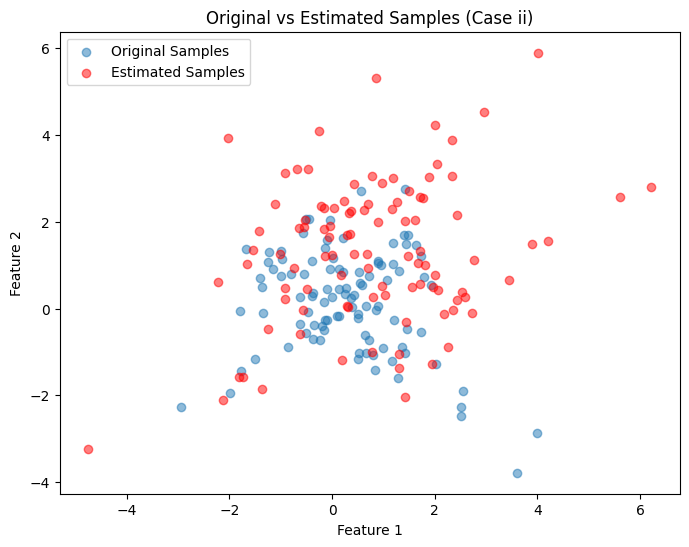

In [54]:
# Iitialization same as before (for the most part)
# Samples from the true GMM
samples = generate_samples_from_GMM(n, d, true_means, true_covariances, true_weights)

# Initialize parameters for EM
initial_means = samples[np.random.choice(np.arange(n), size=K, replace=False)]

# Initialize other parameters
initial_weights = true_weights  # Use true_weights instead of pi
initial_covariances = np.array([np.eye(d) for _ in range(K)])

# Define prior parameters for the second case
lambda_val = 1e3  # Strength of the prior
mu_prior_offset = 1  # Offset for wrong prior mean

# Update the prior mean vectors to be offset from the true mean vectors
prior_means = true_means + mu_prior_offset

# Run EM algorithm
pi, mu, Sigma = em_algorithm(samples, initial_means, initial_covariances, initial_weights, lambda_val, prior_means)

# Output estimated parameters
print("Estimated Mixture Weights:")
print(pi)
print("\nEstimated Mean Vectors:")
print(mu)
print("\nEstimated Covariance Matrices:")
print(Sigma)

# Generate estimated samples using the estimated parameters
estimated_samples_2 = generate_est(n, d, pi, mu, Sigma)

# Scatter plot for original and estimated samples
plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label='Original Samples')
plt.scatter(estimated_samples_2[:, 0], estimated_samples_2[:, 1], color='red', alpha=0.5, label='Estimated Samples')
plt.title('Original vs Estimated Samples (Case ii)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


<ipython-input-52-e0e1327d9b50>:6: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples[i] = np.random.multivariate_normal(true_means[components[i]], true_covariances[components[i]])


Estimated Mixture Weights:
[6.33991557e-01 4.42023084e-04 3.65566420e-01]

Estimated Mean Vectors:
[[0.0820086  0.5961003 ]
 [2.00126838 0.4974741 ]
 [0.99917338 0.05216855]]

Estimated Covariance Matrices:
[[[ 1.29054724  0.90530993]
  [ 0.90530993  1.27706555]]

 [[ 2.03386815 -4.21661027]
  [-4.21661027  8.74507459]]

 [[ 0.92328839 -0.90259521]
  [-0.90259521  1.66948355]]]


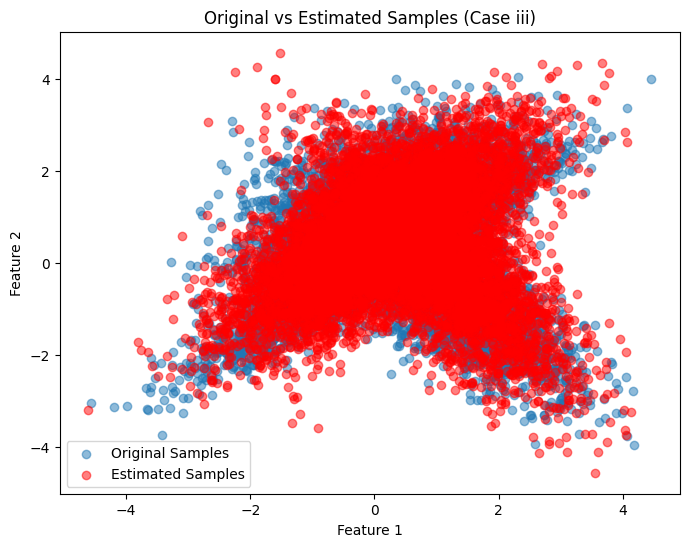

In [56]:
n = 10**4  # Number of samples (updated for case 3)
# Samples from the true GMM
samples = generate_samples_from_GMM(n, d, true_means, true_covariances, true_weights)

# Initialize parameters for EM
# For simplicity, we initialize the mean vectors with random samples from the data
initial_means = samples[np.random.choice(np.arange(n), size=K, replace=False)]

# Initialize other parameters
initial_weights = true_weights  # Use true_weights instead of pi
initial_covariances = np.array([np.eye(d) for _ in range(K)])

# Define prior parameters for the third case
lambda_val = 1e3  # Strength of the prior
mu_prior_offset = 1  # Offset for wrong prior mean

# Update the prior mean vectors to be offset from the true mean vectors
prior_means = true_means + mu_prior_offset

# Run EM algorithm
pi, mu, Sigma = em_algorithm(samples, initial_means, initial_covariances, initial_weights, lambda_val, prior_means)

# Output estimated parameters
print("Estimated Mixture Weights:")
print(pi)
print("\nEstimated Mean Vectors:")
print(mu)
print("\nEstimated Covariance Matrices:")
print(Sigma)

# Generate estimated samples using the estimated parameters
estimated_samples_3 = generate_est(n, d, pi, mu, Sigma)

# Scatter plot for original and estimated samples
plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label='Original Samples')
plt.scatter(estimated_samples_3[:, 0], estimated_samples_3[:, 1], color='red', alpha=0.5, label='Estimated Samples')
plt.title('Original vs Estimated Samples (Case iii)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


# Results

In the first case, with few data points but a strong correct prior, the estimation tends to be relatively good because the prior information guides the model towards the correct parameters, resulting in a tighter clustering around the true distribution. However, in the second case, where there's a strong wrong prior, the estimation appears sparser than the ground truth because the prior information misguides the model, causing it to deviate from the true parameters. Lastly, in the third case, with many data points but still a strong wrong prior, the estimation might seem fitted or included within the ground truth surface because the large amount of data can partially compensate for the misleading prior, but there may still be discrepancies due to the influence of the wrong prior.